In [28]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('/Users/z3402744/Software/SEPAL/src')
import dce_fit, relaxivity, signal_models, water_ex_models, aifs, pk_models
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple ROI analysis

## Define time-points

In [29]:
dt=40  # temporal resolution
t = dt * (np.arange(41) + 0.5);

## Load ROI data for VIF (i.e., SSS) and tissue (i.e., subcortical GM)

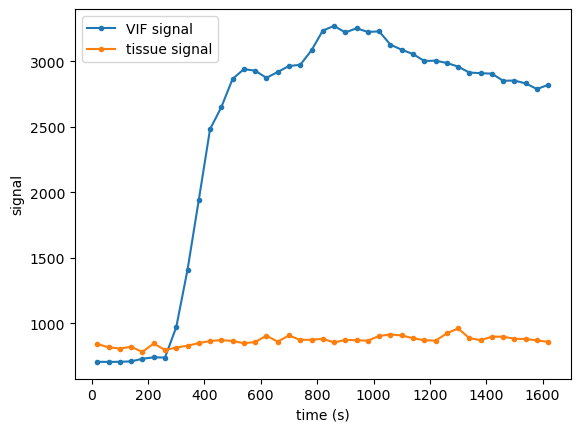

In [42]:
s_vif = np.loadtxt('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/dyn_meants_in_SSS.txt') # signal in vif, i.e., dynamics in SSS.
k_vif = np.loadtxt('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/B1_in_SSS.txt') / 100  # B1 correction factor (actual/nominal flip angle)
                                                                                            # B1 from hMRI is in %, therefore times 100
t1_vif = np.loadtxt('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/T1_in_SSS.txt') / 1000; # pre-contrast T1, before correcting for B1
                                                                                            # T1 from scanner seems to be in milliseconds
                                                                                            # Needs unit of seconds here

s_tissue = np.loadtxt('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/dyn_meants_in_subcorGM.txt')
k_tissue = np.loadtxt('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/B1_in_subcorGM.txt') / 100
t1_tissue = np.loadtxt('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/T1_in_subcorGM.txt') / 1000

hct = 0.395 # haematocrit

plt.plot(t, s_vif, '.-', label='VIF signal')
plt.plot(t, s_tissue, '.-', label='tissue signal')
plt.xlabel('time (s)')
plt.ylabel('signal')
plt.legend();

## Calculate enhancement (signal -> enhancement)

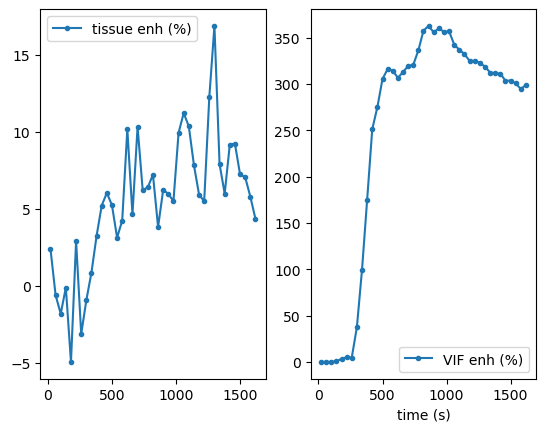

In [43]:
# Do this by creating a SigToEnh object and use the proc method to get enhancement. Use the first three points as the baseline.

s_to_enh = dce_fit.SigToEnh(base_idx=[0, 1, 2])
enh_vif = s_to_enh.proc(s_vif)
enh_tissue = s_to_enh.proc(s_tissue)

fig, ax = plt.subplots(1,2)
ax[0].plot(t, enh_tissue, '.-', label='tissue enh (%)')
ax[1].plot(t, enh_vif, '.-', label='VIF enh (%)')
ax[1].set_xlabel('time (s)');
[a.legend() for a in ax.flatten()];

## Calculate concentration (enhancement -> concentration)

In [44]:
# Define the relationship between concentration and relaxation rate:

c_to_r_model = relaxivity.CRLinear(r1=5.0, r2=7.1) ############ R1/R2 of gd agent from GADOVIST 1.0 document from Siuly

In [45]:
# Define the relationship between relaxation rate and signal:

signal_model = signal_models.SPGR(tr=3.44e-3, fa=15, te=1.68e-3)

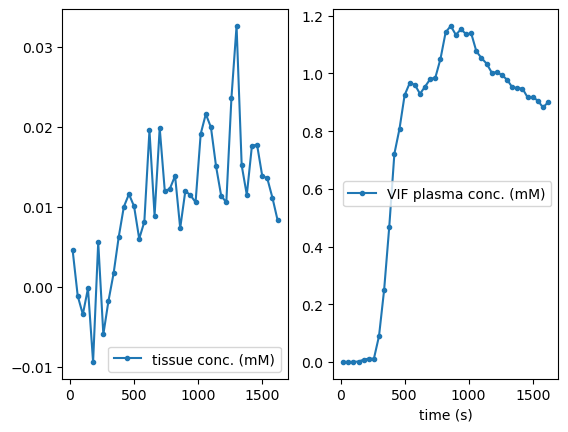

In [46]:
# Create an EnhToConc object and use the proc method to get concentration:

e_to_c = dce_fit.EnhToConc(c_to_r_model, signal_model)

C_t = e_to_c.proc(enh_tissue, t1_tissue, k_tissue)
c_p_vif = e_to_c.proc(enh_vif, t1_vif, k_vif) / (1-hct)

fig, ax = plt.subplots(1,2)
ax[0].plot(t, C_t, '.-', label='tissue conc. (mM)')
ax[1].plot(t, c_p_vif, '.-', label='VIF plasma conc. (mM)')
ax[1].set_xlabel('time (s)');
[a.legend() for a in ax.flatten()];

## Fit the pharmacokinetic model to the concentration

In [47]:
# Create an AIF object based on the calculate VIF concentrations:

aif = aifs.PatientSpecific(t, c_p_vif)

In [48]:
# Create a PKModel object

pk_model = pk_models.Patlak(t, aif, bounds=((-1,-0.001),(1,1)))

vp = 0.0111, ps = 0.000283


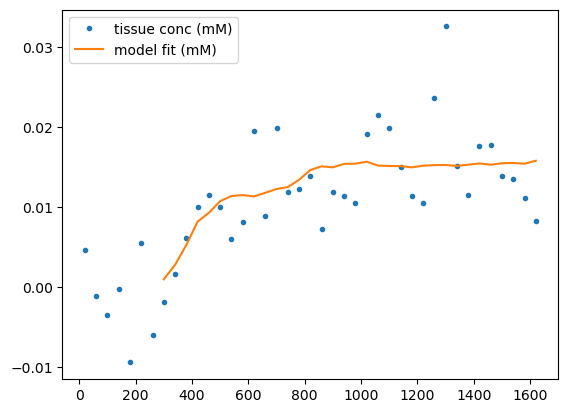

In [49]:
# Create a ConcToPKP object and use the proc method to fit the concentration data:

weights = np.concatenate([np.zeros(7), np.ones(34)]) # exclude first few points from fit
pkp_0 = [{'vp': 0.2, 'ps': 1e-4}] # starting parameters (multiple starting points can be specified if required)

conc_to_pkp = dce_fit.ConcToPKP(pk_model, pkp_0, weights)
vp, ps, C_t_fit = conc_to_pkp.proc(C_t)

plt.plot(t, C_t, '.', label='tissue conc (mM)')
plt.plot(t, C_t_fit, '-', label='model fit (mM)')
plt.legend();

print(f"vp = {vp:.4f}, ps = {ps:.6f}")

## Fit the linearised Patlak model to the concentration

vp = 0.0111, ps = 0.000283


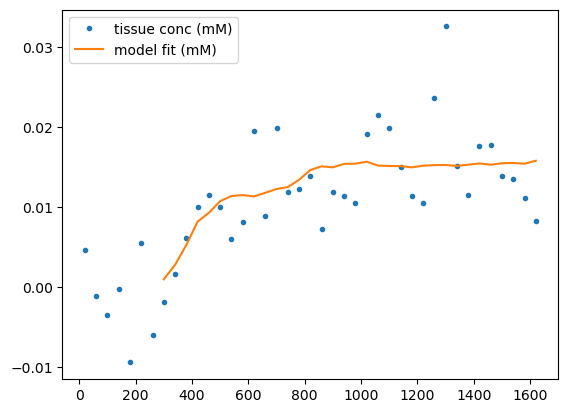

In [50]:
# Method uses linear regression with two regressors: the AIF and the AIF integral.
# This method has faster performance than non-linear fit but is more robust than the classic "graphical" Patlak method.

include = np.concatenate([np.zeros(7), np.ones(34)]) # exclude first few points from fit

conc_to_pkp_lin = dce_fit.PatlakLinear(t, aif, include=include)
vp, ps, C_t_fit = conc_to_pkp_lin.proc(C_t)

plt.plot(t, C_t, '.', label='tissue conc (mM)')
plt.plot(t, C_t_fit, '-', label='model fit (mM)')
plt.legend();

print(f"vp = {vp:.4f}, ps = {ps:.6f}")

## Fit data in signal space
Alternatively, we can fit the enhancement curve directly. To do this, we need to create a water_ex_model object, which determines the relationship between R1 in each tissue compartment and the exponential R1 components. We start by assuming the **fast water exchange limit** (as implicitly assumed above when estimating tissue concentration). The results should be similar to fitting the concentration curve:

vp = 0.0110, ps = 0.000282


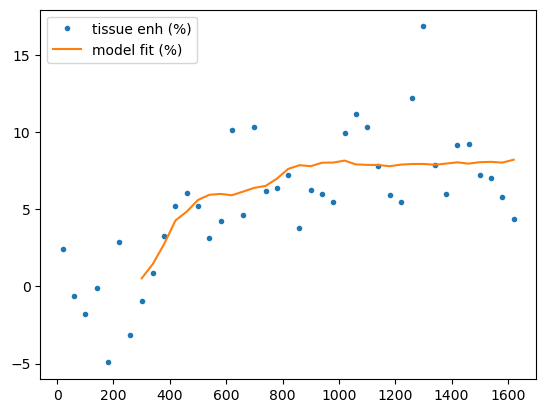

In [51]:
wxm = water_ex_models.FXL()

# This time create an EnhToPKP object and use the proc method to fit the enhancement curve:

enh_to_pkp = dce_fit.EnhToPKP(hct, pk_model, t1_vif, c_to_r_model, wxm, signal_model, pkp_0, weights)

vp, ps, enh_fit = enh_to_pkp.proc(enh_tissue, k_tissue, t1_tissue)

plt.plot(t, enh_tissue, '.', label='tissue enh (%)')
plt.plot(t, enh_fit, '-', label='model fit (%)')
plt.legend();

print(f"vp = {vp:.4f}, ps = {ps:.6f}")

Repeat the fit assuming **slow BBB water exchange**

vp = 0.0129, ps = 0.000275


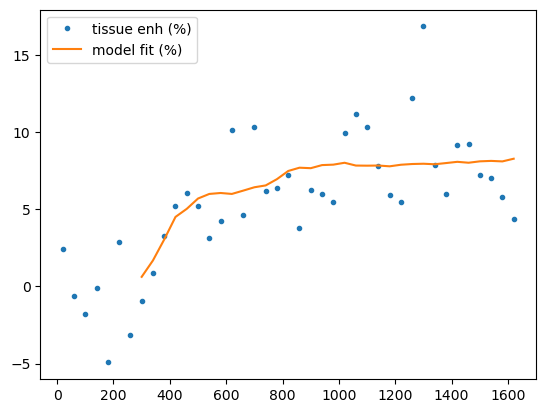

In [52]:
# This time, we assume slow water exchange across the vessel wall. 
# The result will be very different compared with fitting the concentration curve:

wxm_ntexl = water_ex_models.NTEXL()

# Create a new EnhToPKP object using this water exchange model and repeat the fit:

enh_to_pkp_ntexl = dce_fit.EnhToPKP(hct, pk_model, t1_vif, c_to_r_model, wxm_ntexl, signal_model, pkp_0, weights)

vp_ntexl, ps_ntexl, enh_fit_ntexl = enh_to_pkp_ntexl.proc(enh_tissue, k_tissue, t1_tissue)

plt.plot(t, enh_tissue, '.', label='tissue enh (%)')
plt.plot(t, enh_fit_ntexl, '-', label='model fit (%)')
plt.legend();

print(f"vp = {vp_ntexl:.4f}, ps = {ps_ntexl:.6f}")

# Voxel-wise analysis
The fitting objects created above can also be used to fit a 4D DCE image. Instead of the proc method, we use the proc_image method, and some of the arguments are images rather than single values/vectors. proc_image is a method of the base class (i.e. it's the same for all processing steps). It simply calls the subclass's proc method on each voxel in the image.
Refer to proc_image and proc docstrings for further details.

## Calculate enhancement image (signal -> enhancement)
The first argument is the input image, i.e. the re-aligned DCE signal image. This can be the path to a nii file or a np array.
The mask argument provides a binary mask. Only voxels within the mask are processed.
The dir argument indicates where to write the output image. If this is None (default), the results are not written to a file, only to variables.

In [53]:
# Define a function to show images

import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt

def show_img_4d (fname):
    img = nb.load (fname)
    data = img.get_fdata()
    data = np.where(np.isfinite(data), data, 0)  # remove nan
    f = plt.figure(figsize=(12, 12))
    # find minimum of minima & maximum of maxima
    # minmin = np.min([np.min(data[:,:,46,0]), 
    #                  np.min(data[:,:,46,10]),
    #                  np.min(data[:,:,46,20]),
    #                  np.min(data[:,:,46,30]),
    #                  np.min(data[:,:,46,40])])
    # maxmax = np.max([np.max(data[:,:,46,0]), 
    #                  np.max(data[:,:,46,10]),
    #                  np.max(data[:,:,46,20]),
    #                  np.max(data[:,:,46,30]),
    #                  np.max(data[:,:,46,40])])
    data_tmp = data
    data_tmp[data_tmp==0] = np.nan
    robust_max, robust_min = np.nanpercentile(data_tmp, [95 ,5])
    for i in range(5):
        plt.subplot (1,5,i+1)
        plt.imshow (np.rot90 (data [:,:,46,i*10]), vmin=robust_min, vmax=robust_max, cmap = 'jet')
        plt.gca().set_axis_off()
    print (robust_min)
    print (robust_max)

def show_img_3d (fname):
    img = nb.load(fname)
    data = img.get_fdata()
    data = np.where(np.isfinite(data), data, 0)
    f = plt.figure (figsize = (12, 12))
    data_tmp = data
    data_tmp[data_tmp==0] = np.nan
    robust_max, robust_min = np.nanpercentile(data_tmp, [95 ,5])
    for i in range(5):
        plt.subplot (1,5,i+1)
        plt.imshow (np.rot90 (data [:,:,(30 + i * 5)]), vmin=robust_min, vmax=robust_max, cmap = 'jet')
        plt.gca().set_axis_off()
    print (robust_min)
    print (robust_max)

In [54]:
enh_4d = s_to_enh.proc_image(['/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/dynamic_mcf.nii.gz'], 
                             mask='/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/dynamic_Tmean_optiBET_brain_mask.nii.gz', 
                             dir='/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal')

-8.950776576995848
61.86650085449219


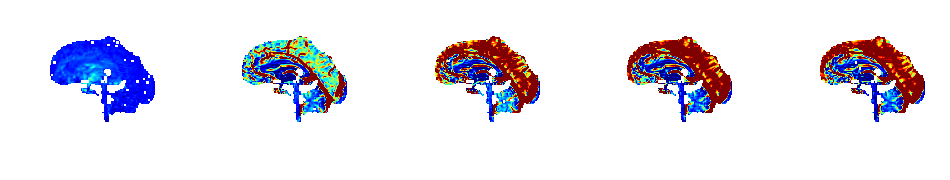

In [55]:
show_img_4d ('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/enh.nii')

## Calculate concentration (enhancement -> concentration)
This time, the input image is the enhancement image (or array).
Additional parameters must also be provided as images: T1 and k (B1+ correction) maps.

In [56]:
C_t_4d = e_to_c.proc_image(['/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/enh.nii'], 
                           arg_images=['/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/T1uncorr_reg2dyn.nii.gz',
                                       '/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/B1map_reg2dyn.nii.gz'], 
                           mask='/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/T1_reg2dyn_optiBET_brain_mask.nii.gz', 
                           dir='/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal')

-1.6654268620186485e-05
7.393104642687826e-05


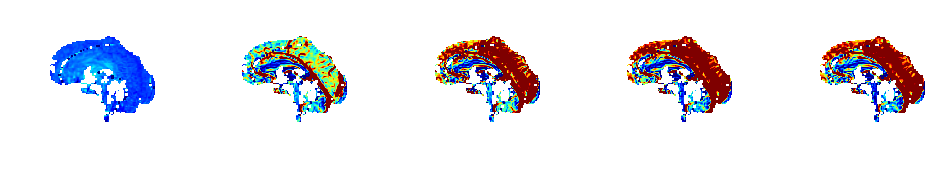

In [58]:
show_img_4d ('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/C_t.nii')

## Fit pharmacokinetic model
This time, the input image is the tissue concentration image.
The output images contain the pharmacokinetic parameters and the fitted concentrations.
For speed, we use multiple cores.

In [59]:
vp_3d, ps_3d, C_t_fit_4d = conc_to_pkp.proc_image('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/C_t.nii', 
                                                  mask='/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/dynamic_Tmean_optiBET_brain_mask.nii.gz', 
                                                  dir='/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal', 
                                                  n_procs=2);

-1.72068685060367e-05
8.698181336512793e-05


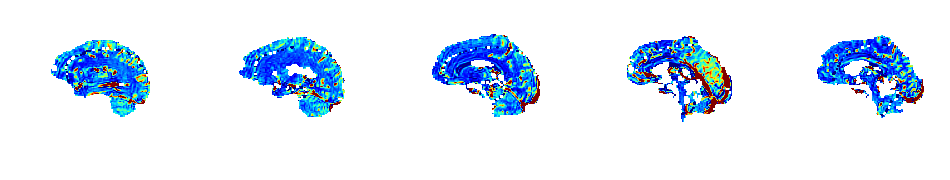

In [60]:
show_img_3d ('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/vp.nii')

-9.72995280790201e-07
1.3425984946024987e-06


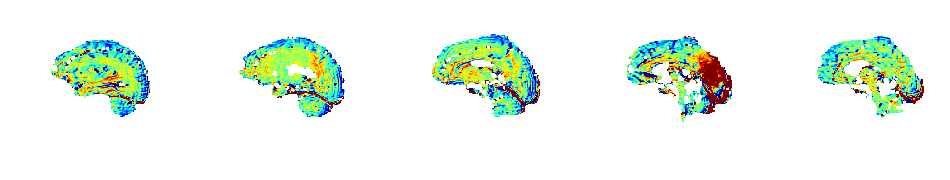

In [61]:
show_img_3d ('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/ps.nii')

-1.4440137874771608e-05
8.471174078295007e-05


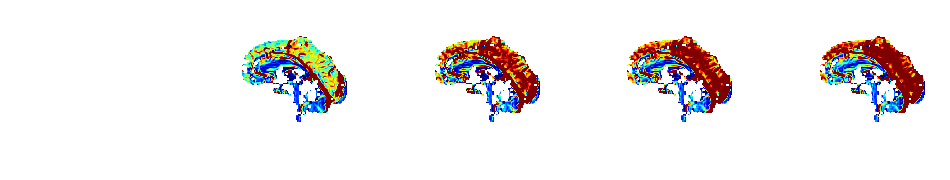

In [62]:
show_img_4d ('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/Ct_fit.nii')

## Fit linear Patlak model

In [63]:
vp_lin_3d, ps_lin_3d, C_t_fit_lin_4d = conc_to_pkp_lin.proc_image('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/C_t.nii', 
                                                                  mask='/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/dynamic_Tmean_optiBET_brain_mask.nii.gz', 
                                                                  dir='/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal', 
                                                                  suffix="_lin", 
                                                                  n_procs=2)

-1.72068685060367e-05
8.698181336512793e-05


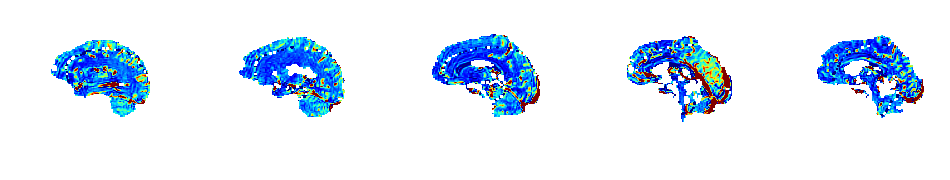

In [64]:
show_img_3d ('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/vp_lin.nii')

-9.72995280790201e-07
1.3425984946024987e-06


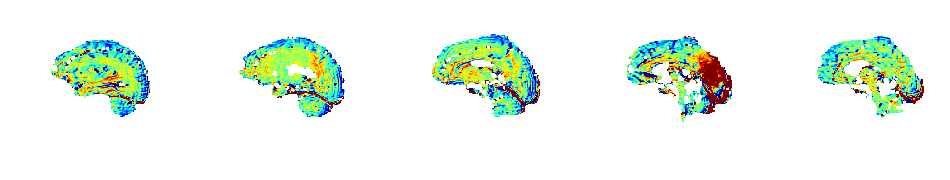

In [65]:
show_img_3d ('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/ps_lin.nii')

-1.4440137874771608e-05
8.471174078295007e-05


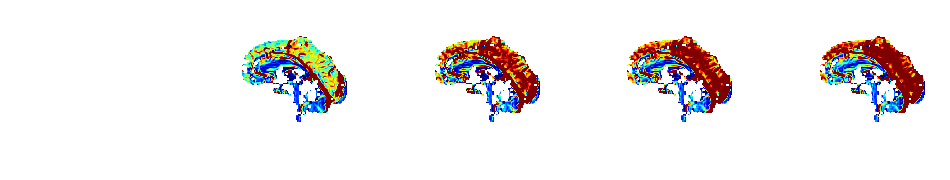

In [66]:
show_img_4d ('/Users/z3402744/Work/vci/vci_001/flywheel/dce/nii/sepal/Ct_fit_lin.nii')